# 水平方向にずれたパターン

# 最初はいくつかのツール

始める前に、画像を扱うためのツールをいくつか作っておきましょう。

* 与えられたサイズと背景を持つ新しい画像を返す関数
* 画像を表示する関数

まずは空の画像ビルダーから始めましょう。scikit-image スタイルを使用し、numpy 配列を使用して画像をモデル化することにします。途中で必要となるパッケージをインポートしましょう。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage, skimage.io
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 50

In [3]:
def blank_image(
    shape: tuple[int]=(600, 800, 4),
    rgba: tuple[int]=(255, 255, 255, 0)
    ) -> np.ndarray:
    """Returns a blank image, of size defined by shape and background color rgb."""
    return np.ones(shape, dtype=np.float) * np.array(rgba) / 255.

In [4]:
img = blank_image()

C:\Users\fairy26\AppData\Local\Temp\ipykernel_5812\1794398283.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.ones(shape, dtype=np.float) * np.array(rgba) / 255.


さて、画像ができたので、それを表示する関数を書いてみましょう。

In [5]:
def display(img: np.ndarray, colorbar: bool=False):
    """Displays an image."""
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        i = skimage.io.imshow(img, cmap='gray')
    else:
        i = skimage.io.imshow(img)
    if colorbar:
        plt.colorbar(i, shrink=0.5, label='depth')
    plt.tight_layout()

c:\Users\fairy26\miniforge3\envs\zzz\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


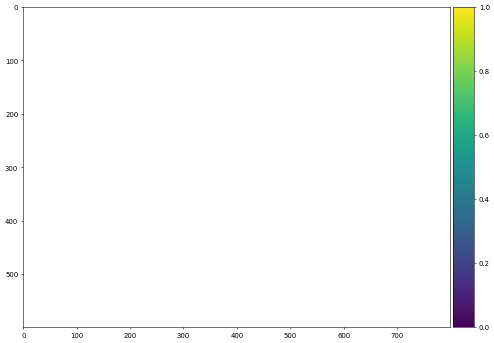

In [6]:
display(img)

# タイル
では、パターンのタイリングについて説明します。まず、この記事で扱うパターンであるコインをロードします。

In [7]:
coin: np.ndarray = skimage.io.imread('files/coin_icon.png')

このコインはどのような形をしていますか？

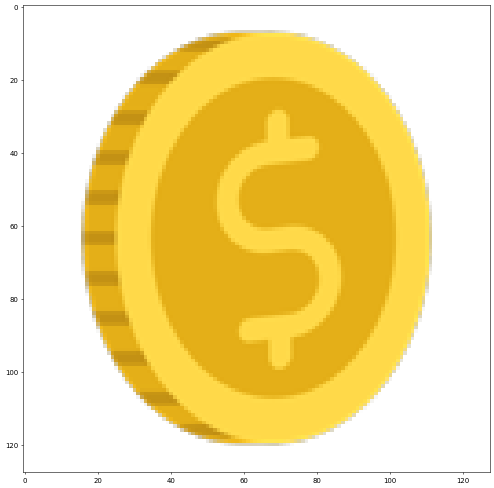

In [30]:
display(coin)

では、既存の画像にパターンを挿入する関数を書いてみましょう。

In [31]:
def insert_pattern(background_img: np.ndarray, pattern: np.ndarray, location: tuple[int]) -> np.ndarray:
    """Inserts a pattern onto a background, at given location. Returns new image."""
    img = background_img.copy()
    r0, c0 = location
    r1, c1 = r0 + pattern.shape[0], c0 + pattern.shape[1]
    if r1 < background_img.shape[0] and c1 < background_img.shape[1]:
        img[r0:r1, c0:c1, :] = skimage.img_as_float(pattern)
    return img

これをテストしてみましょう。

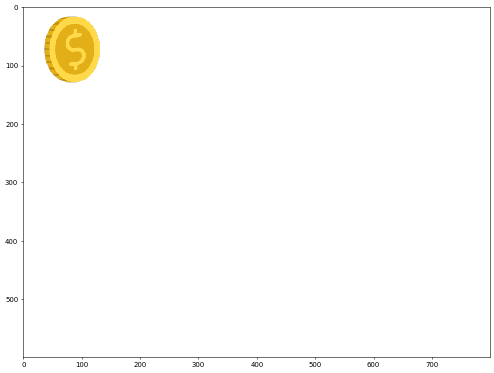

In [10]:
test_img = insert_pattern(img, coin, (10, 20))
display(test_img)

そこから、画像上にパターンを繰り返しマッピングする水平タイル関数を書くことができる。

In [11]:
def tile_horizontally(background_img: np.ndarray, pattern: np.ndarray, start_location: tuple[int], repetitions: int, shift: int) -> np.ndarray:
    """Tiles a pattern on a background image, repeatedly with a given shift."""
    img = background_img.copy()
    for i in range(repetitions):
        r, c = start_location
        c += i * shift
        img = insert_pattern(img, pattern, location=(r, c))
    return img

これをテストしてみましょう。

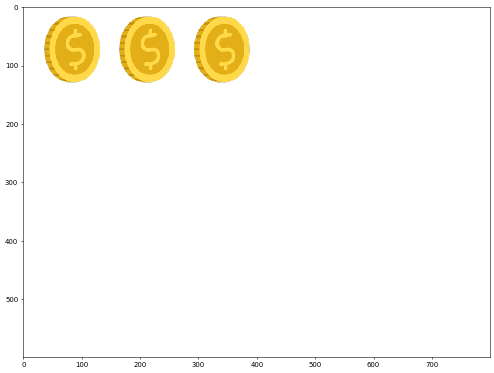

In [12]:
test_img = tile_horizontally(img, coin, (10, 20), 3, 128)
display(test_img)

さて、基本ができたところで、wikipediaのオートステレオグラムのページにある「3列のコインをそれぞれシフトさせる」という例を真似てみましょう。

C:\Users\fairy26\AppData\Local\Temp\ipykernel_5812\1794398283.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.ones(shape, dtype=np.float) * np.array(rgba) / 255.


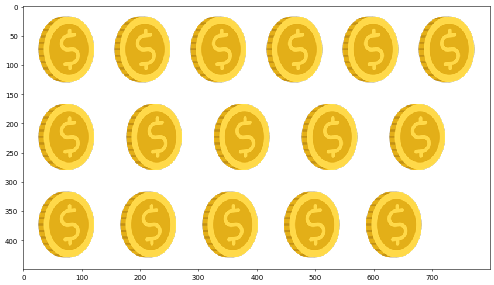

In [13]:
img = blank_image(shape=(450, 800, 4))
img = tile_horizontally(img, coin, (10, 10), 6, shift=130)
img = tile_horizontally(img, coin, (10 + 150, 10), 5, shift=150)
img = tile_horizontally(img, coin, (10 + 2*150, 10), 5, shift=140)
display(img)

この画像をいわゆる壁目線で見ると、真ん中の列が画面の中に押し込まれ、上下の列が浮き出ているように見えると思います。見えますか？

この実験から得られた結論は、「密着しているものは、間隔の広いものよりも近くに見える」ということです。

では、縦方向にも効果があるのでしょうか？3Dパターンを視覚化した後、画面を回転させてみてください。私には、奥行きの錯覚はすぐになくなり、少し傾けるだけで奥行きの印象を壊すのに十分です。

この結果は、すでに興味深いものです。しかし、深度マップベースのステレオグラムはどうでしょうか？

# 深度マップベースのステレオグラム
オートステレオグラムに関するウィキペディアの記事には、深度マップベースのステレオグラムを作成するためのアルゴリズムが次のように記述されています。

>   コンピュータ・プログラムは、深度マップとそれに付随するパターン画像を取り込んで、 オートステレオグラムを生成することができます。プログラムは、深度マップと同じ大きさの領域をカバーするために、パターン画像を水平にタイル状に配置します。具体的には、出力画像の各画素で、深度マップ画像に相当する画素のグレースケール値を調べ、その値からその画素に必要な水平方向の移動量を決定する。  
> これを実現する一つの方法は、出力画像のすべての行を左から右へピクセルごとにスキャンすることです。パターン画像から行の最初のピクセルのシリーズをシードします。そして、深度マップを参照して、後続の画素に適切なシフト値を取得します。各ピクセルについて、パターン画像の幅からシフト値を引き、繰り返し間隔を算出する。この繰り返し間隔を利用して、左隣のピクセルの色を調べ、その色を新しいピクセルの色として使用します。

これだけでは、はっきり言って説明になっていない。これを分解してみましょう。必要なものは2つです。

* パターン
* 深度マップ

まず、パターンを作成しよう。ここでは、グレーの値からなるランダムなパターンを使用する。

In [14]:
def make_pattern(shape: tuple[int]=(16, 16), levels: int=64):
    """Creates a pattern from gray values."""
    return np.random.randint(0, levels - 1, shape) / levels

これをテストしてみましょう。

In [34]:
pattern = make_pattern(shape=(128, 64))

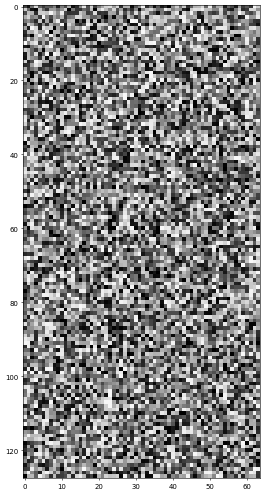

In [35]:
display(pattern)

さて、今度は深度マップを作成したいと思います。単純な円を使って深度マップを作成してみましょう。

In [32]:
def create_circular_depthmap(shape: tuple[int]=(600, 800), center: np.ndarray|None=None, radius: int=100) -> np.ndarray:
    """Creates a circular depthmap, centered on the image."""
    depthmap = np.zeros(shape, dtype=np.float)
    r = np.arange(depthmap.shape[0])
    c = np.arange(depthmap.shape[1])
    R, C = np.meshgrid(r, c, indexing='ij')
    if center is None:
        center = np.array([r.max() / 2, c.max() / 2])
    d = np.sqrt((R - center[0])**2 + (C - center[1])**2)
    depthmap += (d < radius)
    return depthmap 

In [33]:
depthmap = create_circular_depthmap(radius=150)

C:\Users\fairy26\AppData\Local\Temp\ipykernel_5812\2568307384.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  depthmap = np.zeros(shape, dtype=np.float)


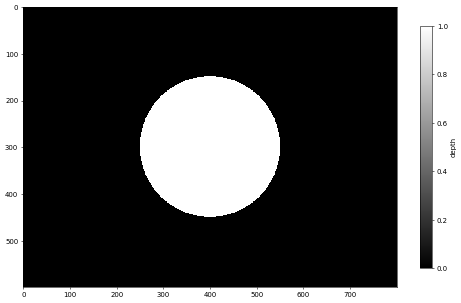

In [19]:
display(depthmap, colorbar=True)

せっかくなので、デプスマップを[0, 1]の範囲に正規化する関数も作っておきましょう。

In [20]:
def normalize(depthmap: np.ndarray) -> np.ndarray:
    """Normalizes values of depthmap to [0, 1] range."""
    if depthmap.max() > depthmap.min():
        return (depthmap - depthmap.min()) / (depthmap.max() - depthmap.min())
    else:
        return depthmap

最後に、アルゴリズムを適用してみましょう。

In [21]:
def make_autostereogram(depthmap: np.ndarray, pattern: np.ndarray, shift_amplitude: float=0.1, invert: bool=False) -> np.ndarray:
    """Creates an autostereogram from depthmap and pattern."""
    depthmap = normalize(depthmap)
    if invert:
        depthmap = 1 - depthmap
    autostereogram = np.zeros_like(depthmap, dtype=pattern.dtype)
    for r in np.arange(autostereogram.shape[0]):
        for c in np.arange(autostereogram.shape[1]):
            if c < pattern.shape[1]:
                autostereogram[r, c] = pattern[r % pattern.shape[0], c]
            else:
                shift = int(depthmap[r, c] * shift_amplitude * pattern.shape[1])
                autostereogram[r, c] = autostereogram[r, c - pattern.shape[1] + shift]
    return autostereogram

テストしてみよう

In [22]:
autostereogram = make_autostereogram(depthmap, pattern)

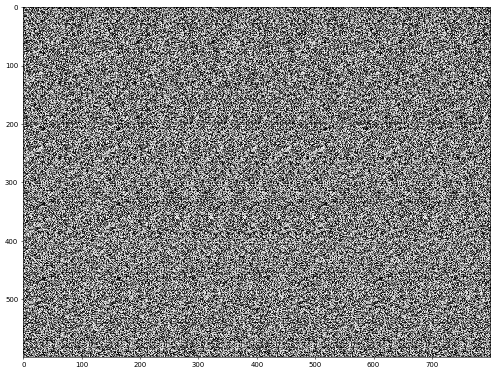

In [23]:
display(autostereogram)

倒立型はどうでしょう？

In [24]:
autostereogram = make_autostereogram(depthmap, pattern, invert=True)

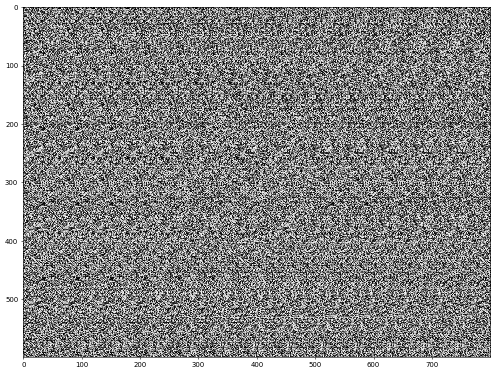

In [25]:
display(autostereogram)

これも効果あり！

もっと凝ったパターンも見てみましょう。例えば、異なるデプスマップを組み合わせることができます。

In [26]:
depthmap = create_circular_depthmap(center=(200, 300), radius=100) + \
           create_circular_depthmap(center=(450, 500), radius=100) + \
           create_circular_depthmap(center=(200, 550), radius=150)
depthmap = normalize(depthmap)

C:\Users\fairy26\AppData\Local\Temp\ipykernel_5812\1804866734.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  depthmap = np.zeros(shape, dtype=np.float)


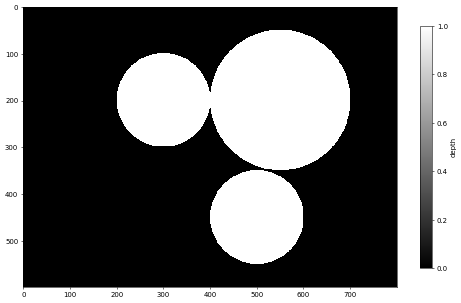

In [27]:
display(depthmap, colorbar=True)

In [28]:
autostereogram = make_autostereogram(depthmap, pattern)

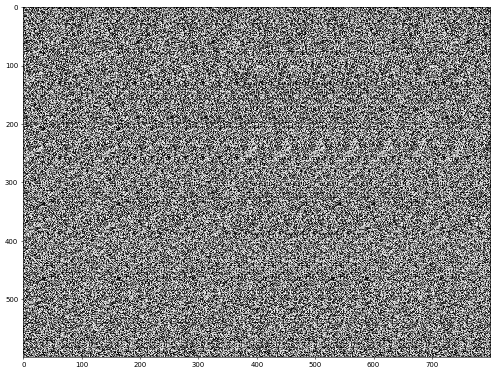

In [29]:
display(autostereogram)

# 結論
今回は、オートステレオグラムの作成方法についてご紹介しました。結果は完璧ではありませんが、奥行きの錯覚は主にパターンの水平方向のずれによって作り出されることがわかり、興味深いものでした。私は、この記事の続きを書き、オートステレオグラムの素晴らしさ（パターンの選択、深度係数、グレーレベルの数...）を探求し、この技術のより興味深いアプリケーションのいくつかを実証する予定です。例えば、地図、データ、数学関数などです。もう1つの興味深いトピックは、すでに他のブログで検討されていますが、オートステレオグラムからデプスマップへの逆変換をどのように生成するかということです。これはまた別の機会に紹介したいと思います。

この記事はすべてIPythonノートブックで書かれています。この記事の内容はBSDライセンスです。[20160803_Autostereograms.ipynb](https://nbviewer.org/github/flothesof/posts/blob/master/20160803_Autostereograms.ipynb) で nbviewer を使ってこのノートブックの静止画を見たり、ダウンロードしたりすることができます。